<h1><b> CLUSTERING-CITRA-SATELIT </b></h1>

---

<div style="background-color:#02D128; padding:10px; border-radius:3px; color:black"> <b>📝 Notebook: 5_clustering_citra_satelit.ipynb</b></div>

Notebook ini merupakan **tahap utama** dalam proyek *Clustering Citra Satelit Sekolah* setelah proses **deteksi anomali** selesai dilakukan.  
Tujuannya adalah **mengelompokkan citra sekolah berdasarkan kemiripan visualnya**, sehingga sekolah-sekolah dengan karakteristik citra yang serupa (misalnya bentuk bangunan, lingkungan sekitar, atau warna dominan) akan berada dalam satu kelompok (*cluster*).

Pendekatan ini membantu dalam **analisis pola visual antar sekolah** di berbagai wilayah, serta mendukung eksplorasi berbasis data citra satelit untuk tujuan **identifikasi sekolah layak dan tidak layak** berdasarkan kondisi visual lingkungannya.

---

📂 **Sumber Data**

Data yang digunakan dalam notebook ini merupakan hasil bersih dari tahap deteksi anomali:

- **`../data/data_deteksi_anomali.csv`** → metadata sekolah lengkap beserta label anomali.  
- **`../hasil/features/features/ResNet50.npy`** → file berisi vektor fitur hasil ekstraksi citra.  
- **`../data/gambar/...`** → citra satelit sekolah untuk keperluan visualisasi hasil clustering.

Total data yang digunakan adalah seluruh citra sekolah **non-anomali** dari dataset sebanyak **14.076 sekolah**, yang telah melalui tahap pembersihan dan validasi.

---

⚙️ **Tahapan Clustering**

Proses clustering dilakukan melalui beberapa langkah sistematis sebagai berikut:

1. **LIBRARY**  
   Mengimpor library yang diperlukan seperti `numpy`, `pandas`, `sklearn`, dan `matplotlib` untuk analisis dan visualisasi.

2. **CONFIGURATION**  
   Menentukan parameter awal seperti jenis fitur yang digunakan, jumlah cluster, serta path input/output.

3. **LOAD METADATA & FITUR**  
   Memuat metadata dan fitur hasil ekstraksi yang sudah dibersihkan dari data anomali.
   Melakukan normalisasi pada vektor fitur agar memiliki skala yang seragam dan siap untuk proses clustering.

4. **CLUSTERING MODEL**  

5. **VISUALISASI HASIL**  
   - Visualisasi hasil clustering dalam ruang **PCA 2D dan 3D** untuk melihat sebaran tiap cluster.  
   - Menampilkan contoh citra dari masing-masing cluster.  
   - Menyediakan interaktif plot (opsional) menggunakan Plotly.

6. **PENYIMPANAN HASIL**  
   Menyimpan hasil akhir dalam bentuk:  
   - `data_clustering.csv` (berisi metadata + label cluster)  
   - Visualisasi distribusi cluster  
   - Folder hasil clustering untuk tiap fitur dan metode.

---

📊 **Hasil yang Diperoleh**

Notebook ini menghasilkan:

- Label cluster untuk setiap sekolah  
- Visualisasi distribusi cluster dalam ruang PCA 2D/3D  
- Contoh citra per-cluster untuk interpretasi hasil  
- Nilai metrik evaluasi clustering (Silhouette Score, Davies–Bouldin Index)  
- File hasil akhir `../data/data_clustering.csv`  

Semua hasil analisis dan visualisasi disimpan di folder:  
📂 **`../hasil/clustering/`**

---

✨ **Tujuan Akhir**

Notebook ini bertujuan untuk:  

- Mengelompokkan sekolah berdasarkan **kemiripan pola visual citra satelit**,  
- Memberikan **wawasan visual** mengenai pola spasial antar sekolah,  
- Menjadi dasar untuk analisis lanjutan seperti:
  - **Karakterisasi cluster** berdasarkan kondisi fisik sekolah,  
  - **Pemetaan sekolah layak dan tidak layak** dari hasil cluster,  
  - **Dukungan pengambilan keputusan** untuk kebijakan pemerataan sarana pendidikan.  

---


---
# **LIBRARY**
---

In [15]:
# ============================
# Standard Library
# ============================
import os
from tqdm import tqdm

# ============================
# Data Manipulation
# ============================
import numpy as np
import pandas as pd

# ============================
# Image Processing
# ============================
import cv2
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from skimage.feature import hog, local_binary_pattern

# ============================
# Visualization
# ============================
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio

# Pengaturan tampilan plot
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")
pio.renderers.default = 'notebook_connected'

# ============================
# Feature Analysis & Clustering
# ============================
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


import plotly.express as px
from sklearn.decomposition import PCA

import plotly.express as px
from sklearn.decomposition import PCA
import numpy as np


---
# **CONFIGURATION**
---

Bagian ini digunakan untuk menyiapkan **path direktori input dan output**, serta parameter dasar yang dibutuhkan untuk proses clustering citra.  
Tujuannya agar seluruh notebook lebih terstruktur dan mudah diatur jika lokasi data atau hasil berubah.

📂 **Konfigurasi utama yang diatur**:  
1. **Path metadata** → lokasi file CSV hasil deteksi anomali (`METADATA_DIR = "../data/data_deteksi_anomali.csv"`)  
2. **Path fitur** → lokasi file .npy fitur citra ResNet50 (`FEATURES_DIR = "../hasil/features/features/resnet50_features_filtered.npy"`)  
3. **Path output** → lokasi penyimpanan hasil clustering (`OUTPUT_DIR = "../hasil/clustering/"`)  
4. **Parameter dasar** → misalnya `RANDOM_STATE = 42` untuk reproduksibilitas analisis


In [3]:
# ============================
# Paths
# ============================
METADATA_DIR = "../data/data_deteksi_anomali.csv"  # Metadata sekolah + label anomali
FEATURES_DIR = "../hasil/features/features/resnet50_features_filtered.npy"  # File .npy fitur citra
OUTPUT_DIR = "../hasil/clustering/"  # Folder hasil clustering

# Membuat folder output jika belum ada
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ============================
# Random State & Reproducibility
# ============================
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


---
# **LOAD METADATA & FITUR**
---

Bagian ini digunakan untuk menyiapkan **data yang akan digunakan untuk clustering**.  
Data yang digunakan hanya **sekolah non-anomali** berdasarkan hasil deteksi anomali sebelumnya.  

Prosesnya dibagi menjadi 3 langkah utama:

1. **Load Metadata**  
   - Memuat metadata sekolah dari file CSV (`METADATA_DIR`)  
   - Menghapus data yang ditandai sebagai anomali (`anomaly_label == 1`)  

2. **Load Features**  
   - Memuat fitur citra yang telah diekstraksi sebelumnya (`.npy`)  
   - Memastikan jumlah baris fitur sama dengan metadata bersih  

3. **Normalisasi Fitur**  
   - Melakukan normalisasi fitur menggunakan `MinMaxScaler`  
   - Membuat skala fitur seragam agar siap untuk proses clustering

In [108]:
# ============================================
# 📥 LOAD METADATA
# ============================================

df_ori = pd.read_csv(METADATA_DIR)
print(f"Total data awal: {df_ori.shape[0]} sekolah")

# Hapus data yang ditandai sebagai anomali (anomaly_label == 1)
df_clean = df_ori[df_ori['anomali'] == 0].reset_index(drop=True)
print(f"Total data non-anomali: {df_clean.shape[0]} sekolah")


Total data awal: 14076 sekolah
Total data non-anomali: 13940 sekolah


In [7]:
# ============================================
# 📥 LOAD FEATURE CITRA
# ============================================

features = np.load(FEATURES_DIR)
print(f"Fitur citra dimensi: {features.shape}")

# Pastikan jumlah baris fitur sama dengan metadata bersih
if features.shape[0] != df_clean.shape[0]:
    raise ValueError("Jumlah fitur dan metadata tidak sesuai setelah menghapus anomali!")

Fitur citra dimensi: (13940, 100352)


In [8]:
# ============================================
# ⚖️ NORMALISASI FITUR
# ============================================

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)
print("✅ Data fitur berhasil dinormalisasi dan siap untuk clustering.")

✅ Data fitur berhasil dinormalisasi dan siap untuk clustering.


---
# **CLUSTERING**
---

Bab ini dibagi menjadi 5 tahap utama:

1. **Reduksi Dimensi PCA**  
   Mereduksi dimensi fitur citra agar clustering lebih cepat dan mudah divisualisasi.

2. **Visualisasi PCA 3D Interaktif**  
   Melihat distribusi sekolah secara 3D dan memeriksa pola cluster sebelum analisis.

3. **Inspect Cluster**  
   Menampilkan akreditasi, provinsi, dan contoh gambar sekolah tiap cluster.

4. **K-Means Clustering**  
   Clustering dengan k = 1–10, dievaluasi menggunakan Elbow dan Silhouette Score.

5. **Interpretasi Hasil**  
   Menentukan sekolah **layak** (dominan A) dan **tidak layak** (dominan B+C), dengan insight visual dari citra satelit.

Dengan kombinasi **PCA + K-Means**, sekolah dapat dikelompokkan otomatis berdasarkan kesamaan visual citra satelit dan dianalisis layak/tidak layak.


---
## **1. Reduksi Dimensi PCA**
---

Data fitur citra dari ResNet50 memiliki dimensi sangat tinggi. Sebelum clustering, digunakan **PCA (Principal Component Analysis)** untuk mereduksi dimensi menjadi lebih kecil (misal 100 komponen).  
Tujuannya agar proses clustering lebih cepat, mengurangi noise, dan mempermudah visualisasi.

- Dimensi awal: `(13940, 100352)`  
- Dimensi setelah PCA: `(13940, 100)`

In [65]:
# ============================
# Reduksi Dimensi PCA
# ============================
n_pca_components = 100  # bisa diubah sesuai eksperimen
pca = PCA(n_components=n_pca_components, random_state=RANDOM_STATE)
features_reduced = pca.fit_transform(features_scaled)
print(f"Dimensi fitur setelah PCA: {features_reduced.shape}")


Dimensi fitur setelah PCA: (13940, 100)


---
## **2. K-Means Cluster**
---

Clustering dilakukan untuk jumlah cluster `k` dari 1 hingga 10.  

Evaluasi dilakukan dengan:  
- **Inertia** → untuk metode Elbow, melihat jumlah cluster optimal  
- **Silhouette Score** → mengukur seberapa baik cluster terbentuk  

Hasil analisis menunjukkan distribusi cluster dan sebaran akreditasi di tiap cluster.


Clustering...: 100%|██████████| 10/10 [00:25<00:00,  2.51s/it]


✅ Semua hasil clustering disimpan di ../hasil/clustering/data_clustering.csv


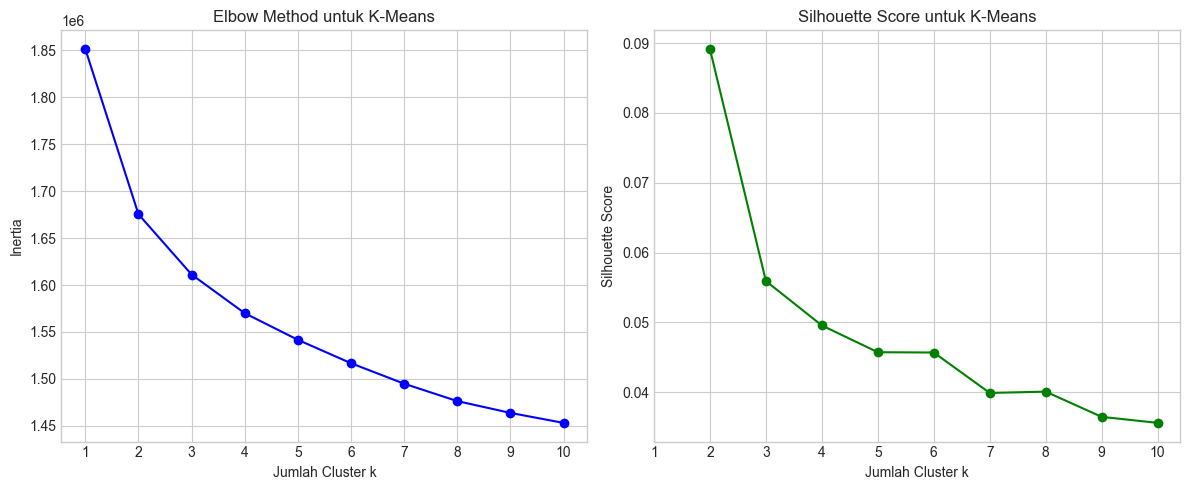

In [109]:
# ============================================
# K-MEANS CLUSTERING (k=1 sampai 10)
# ============================================

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

k_values = range(1, 11)
inertia_list = []
silhouette_list = []

for k in tqdm(k_values, desc="Clustering..."):
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE)
    cluster_labels = kmeans.fit_predict(features_reduced)
    
    # Simpan label cluster ke metadata (dinamis)
    col_name = f"cluster_kmeans_{k}"
    df_clean[col_name] = cluster_labels
    
    # Hitung inertia
    inertia_list.append(kmeans.inertia_)
    
    # Hitung Silhouette Score (hanya untuk k > 1)
    if k > 1:
        sil_score = silhouette_score(features_reduced, cluster_labels)
        silhouette_list.append(sil_score)
    else:
        silhouette_list.append(np.nan)

# ============================
# Simpan hasil clustering
# ============================
df_clean.to_csv(os.path.join(OUTPUT_DIR, "data_clustering.csv"), index=False)
print(f"✅ Semua hasil clustering disimpan di {OUTPUT_DIR}data_clustering.csv")

# ============================
# Plot Elbow & Silhouette
# ============================
plt.figure(figsize=(12,5))

# Elbow plot (Inertia)
plt.subplot(1,2,1)
plt.plot(k_values, inertia_list, 'o-', color='blue')
plt.xlabel("Jumlah Cluster k")
plt.ylabel("Inertia")
plt.title("Elbow Method untuk K-Means")
plt.xticks(k_values)

# Silhouette plot
plt.subplot(1,2,2)
plt.plot(k_values, silhouette_list, 'o-', color='green')
plt.xlabel("Jumlah Cluster k")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score untuk K-Means")
plt.xticks(k_values)

plt.tight_layout()
plt.show()

Berdasarkan **Elbow Method**, terdapat dua titik yang menonjol sebagai kandidat jumlah cluster yang optimal, yaitu:

- **k = 2**  
- **k = 5**

Analisis selanjutnya akan difokuskan pada kedua nilai ini.  

- **k = 2**: Memberikan pemisahan sederhana, cocok untuk klasifikasi **sekolah layak vs tidak layak**.  
- **k = 5**: Menyediakan pemisahan lebih detail antar cluster, memungkinkan identifikasi sub-kelompok dengan karakteristik visual yang berbeda.  

Dengan fokus pada kedua nilai ini, kita dapat membandingkan hasil clustering sederhana dan lebih kompleks, sekaligus mengevaluasi distribusi akreditasi dan visualisasi sekolah di masing-masing cluster.


---
## **3. Visualsisasi PCA 3D Interaktif**
---

Distribusi data divisualisasikan menggunakan **PCA 3D interaktif**.  

- Tiap titik mewakili satu sekolah  
- Bisa dihover untuk menampilkan **nama sekolah** atau **label cluster**  
- Membantu melihat apakah ada pemisahan natural antar cluster sebelum analisis lebih lanjut


In [67]:
# ============================================
# 🌐 VISUALISASI PCA 3D INTERAKTIF
# ============================================
def plot_pca_3d_interactive(features_list, feature_names, y, index, feature_idx=0, marker_size=4):
    """
    Visualisasi PCA 3D interaktif untuk 1 fitur dengan menampilkan nama sekolah saat dihover.
    
    Parameters:
    - features_list : list of np.array, daftar fitur
    - feature_names : list of str, nama fitur
    - y             : np.array atau Series, label cluster
    - index         : Series atau DataFrame, kolom untuk hover (misal nama_sekolah)
    - feature_idx   : int, index fitur yang ingin divisualisasi
    - marker_size   : int, ukuran titik
    """
    
    X = features_list[feature_idx]
    name = feature_names[feature_idx]
    
    # PCA 3D
    pca3 = PCA(n_components=3, random_state=42)
    X_pca3 = pca3.fit_transform(X)
    
    # Visualisasi interaktif
    fig = px.scatter_3d(
        x=X_pca3[:,0],
        y=X_pca3[:,1],
        z=X_pca3[:,2],
        color=[str(label) for label in y],
        labels={'color':'Cluster'},
        title=f"{name} PCA 3D Interaktif",
        width=900,
        height=700,
        hover_name=index
    )
    
    fig.update_traces(marker=dict(size=marker_size))
    fig.show()


In [97]:
plot_pca_3d_interactive(
    features_list=[features_scaled],
    feature_names=["resnet50"],
    y=df_clean['cluster_kmeans_2'],
    index=df_clean['nama_sekolah'],
    feature_idx=0,
    marker_size=2
)

In [98]:
plot_pca_3d_interactive(
    features_list=[features_scaled],
    feature_names=["resnet50"],
    y=df_clean['cluster_kmeans_5'],
    index=df_clean['nama_sekolah'],
    feature_idx=0,
    marker_size=2
)

Dapat dilihat dari visualisasi PCA 3D interaktif bahwa **cluster dengan n = 2** menunjukkan pola yang hampir sama dengan sebaran akreditasi yang telah dianalisis sebelumnya pada tahap ekstraksi fitur. Hal ini menunjukkan bahwa **cluster n = 2** menangkap pola utama dari akreditasi, namun klasifikasinya masih terlalu umum.

Sementara itu, **cluster n = 5** lebih cocok karena mampu memisahkan kelompok-kelompok sekolah dengan lebih detail, sehingga memberikan informasi yang lebih detail mengenai karakteristik visual tiap cluster.

> Perlu dicatat bahwa perbedaan antara akreditasi dan hasil analisis citra satelit adalah hal yang wajar, karena **akreditasi sekolah tidak hanya ditentukan dari kondisi bangunan**, tetapi juga faktor lain seperti kurikulum, kualitas guru, fasilitas pendidikan, dsb.


---
## **4. Inspeksi Cluster**
---

Setelah clustering, tiap cluster dianalisis menggunakan fungsi inspeksi:  

- Menampilkan **total akreditasi keseluruhan**  
- Menunjukkan **jumlah dan persentase akreditasi** di tiap cluster  
- Menampilkan **contoh gambar sekolah** untuk tiap cluster  
- Informasi tambahan: **provinsi** dan **akreditasi** tiap sekolah

Hasil inspeksi ini mempermudah memahami karakteristik visual tiap cluster.

- Beberapa cluster didominasi sekolah dengan akreditasi **A** → bisa dikategorikan sebagai **sekolah layak**  
- Cluster lain didominasi **B** dan **C** → dikategorikan sebagai **sekolah tidak layak**  
- Visualisasi PCA 3D membantu melihat pemisahan antar cluster dan potensi noise  

In [104]:
def inspect_cluster(df, cluster_col, img_col='dir_gambar_ori', samples_per_cluster=3):
    """
    Fungsi otomatis menggabungkan cluster menjadi 2 kategori:
    - Layak  : cluster yang didominasi A
    - Tidak layak : cluster yang didominasi B+C
    
    Menampilkan:
    - Total akreditasi keseluruhan (A / B+C)
    - Jumlah & persentase tiap kategori
    - Contoh gambar tiap kategori (dengan provinsi & akreditasi)
    
    Parameters:
    - df               : DataFrame, data sekolah
    - cluster_col      : str, nama kolom cluster
    - img_col          : str, kolom yang berisi path gambar
    - samples_per_cluster: int, jumlah contoh gambar per kategori
    """
    # Hitung total akreditasi
    total_A = (df['akreditasi'] == 'A').sum()
    total_BC = (df['akreditasi'] != 'A').sum()  # gabungkan B+C
    total_count = len(df)
    
    print(f"📊 Total akreditasi keseluruhan: A: {total_A} | B+C: {total_BC} | Total: {total_count}")
    
    # Tentukan kategori tiap cluster
    cluster_category = {}
    clusters = df[cluster_col].unique()
    
    for cl in clusters:
        cluster_df = df[df[cluster_col] == cl]
        count_A = (cluster_df['akreditasi'] == 'A').sum()
        count_BC = (cluster_df['akreditasi'] != 'A').sum()
        if count_A >= count_BC:
            cluster_category[cl] = 'Layak'
        else:
            cluster_category[cl] = 'Tidak Layak'
    
    # Tambahkan kolom kategori
    df['kategori'] = df[cluster_col].map(cluster_category)
    
    # Tampilkan jumlah & persentase tiap kategori
    print("\n📊 Statistik kategori:")
    for cat in ['Layak', 'Tidak Layak']:
        cat_df = df[df['kategori'] == cat]
        count_A = (cat_df['akreditasi'] == 'A').sum()
        count_BC = (cat_df['akreditasi'] != 'A').sum()
        perc_A = round(count_A / total_A * 100, 2)
        perc_BC = round(count_BC / total_BC * 100, 2)
        print(f"- {cat}: A {count_A} ({perc_A}%), B+C {count_BC} ({perc_BC}%), Total {len(cat_df)}")
        
        # Plot contoh gambar
        sample_df = cat_df.sample(min(samples_per_cluster, len(cat_df)), random_state=42)
        plt.figure(figsize=(samples_per_cluster*4, 4))
        for i, row in enumerate(sample_df.itertuples(), 1):
            img_path = getattr(row, img_col)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.subplot(1, samples_per_cluster, i)
            plt.imshow(img)
            plt.axis('off')
            prov = getattr(row, 'provinsi')
            akr = getattr(row, 'akreditasi')
            plt.title(f"{row.Index}\n{prov} | {akr}", fontsize=9)
        plt.suptitle(f"Contoh gambar kategori: {cat}", fontsize=12)
        plt.show()


📊 Total akreditasi keseluruhan: A: 6699 | B+C: 7241 | Total: 13940

📊 Statistik kategori:
- Layak: A 4018 (59.98%), B+C 2886 (39.86%), Total 6904


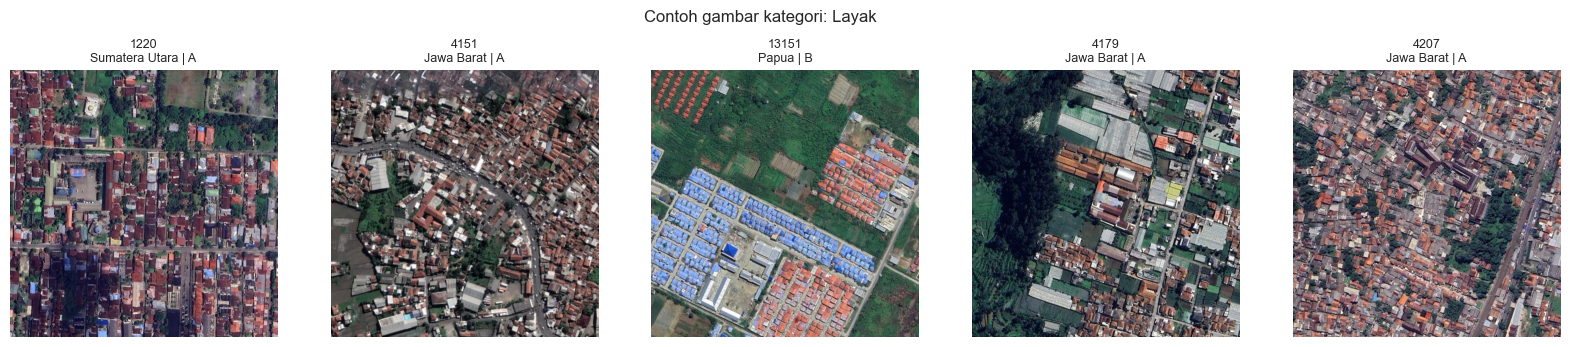

- Tidak Layak: A 2681 (40.02%), B+C 4355 (60.14%), Total 7036


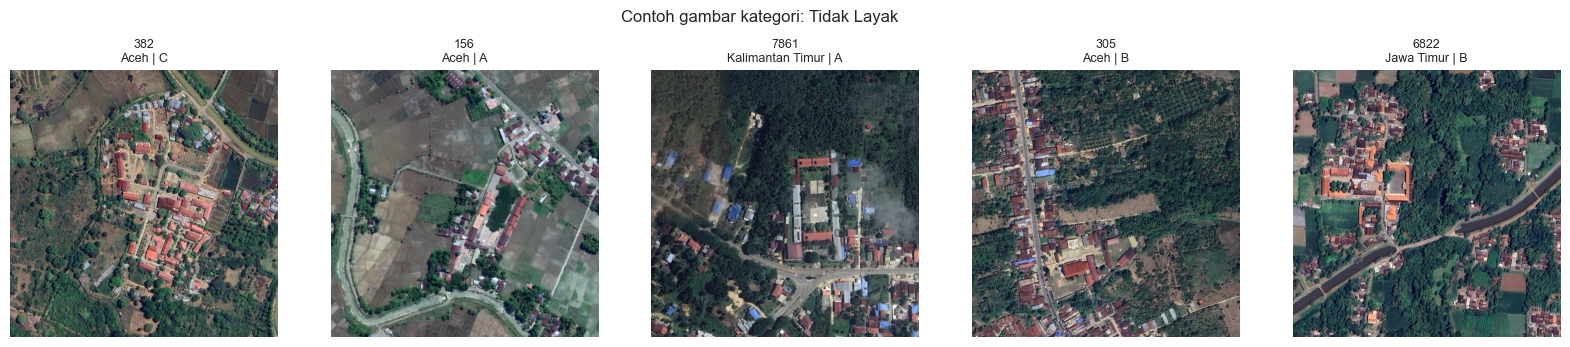

In [105]:
inspect_cluster(df_clean, cluster_col='cluster_kmeans_2', samples_per_cluster=5)

📊 Total akreditasi keseluruhan: A: 6699 | B+C: 7241 | Total: 13940

📊 Statistik kategori:
- Layak: A 4497 (67.13%), B+C 3538 (48.86%), Total 8035


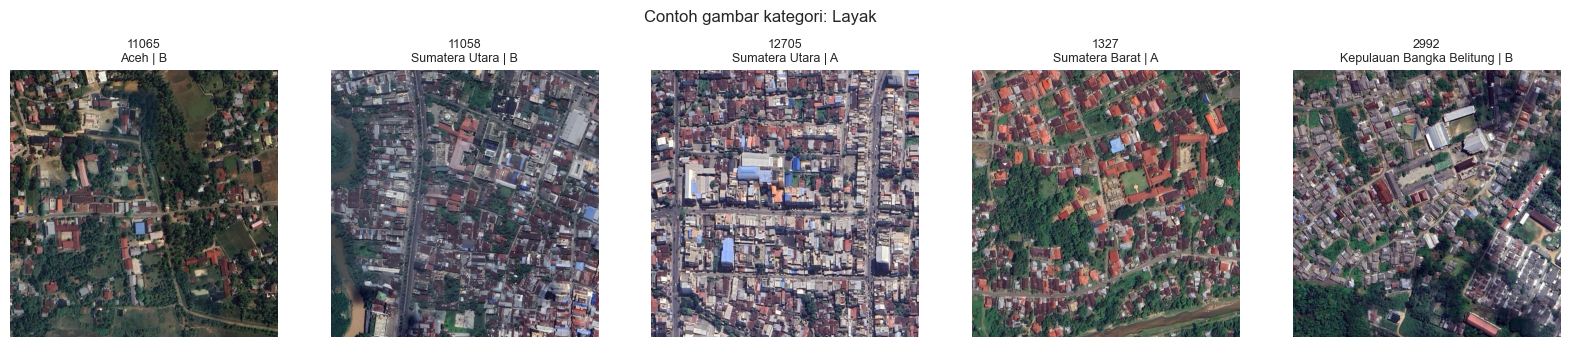

- Tidak Layak: A 2202 (32.87%), B+C 3703 (51.14%), Total 5905


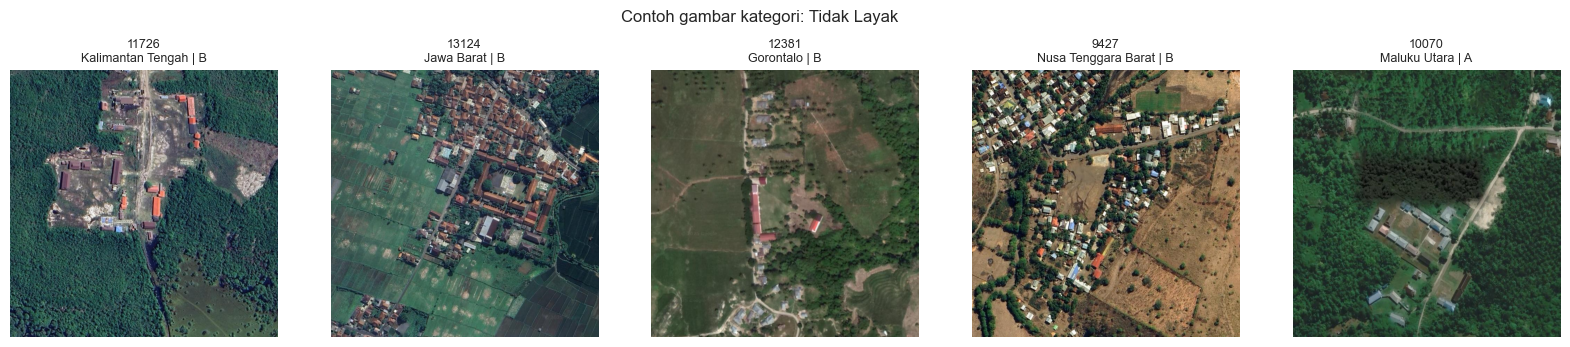

In [106]:
inspect_cluster(df_clean, cluster_col='cluster_kmeans_5', samples_per_cluster=5)

---

n = 2

| Akreditasi \ Kelayakan | Layak | Tidak Layak |
|------------------------|-------|-------------|
| A                      | 4018  | 2681        |
| B + C                  | 2886  | 4355        |

Persentase

| Akreditasi \ Kelayakan | Layak   | Tidak Layak |
|------------------------|---------|-------------|
| A                      | 60%  | 40%      |
| B + C                  | 40%  | 60%      |

**Total**
- Layak: 6904  
- Tidak Layak: 7036

---

n = 5

| Akreditasi \ Kelayakan | Layak | Tidak Layak |
|------------------------|-------|-------------|
| A                      | 4997  | 3538        |
| B + C                  | 2202  | 3703        |

Persentase

| Akreditasi \ Kelayakan | Layak   | Tidak Layak |
|------------------------|---------|-------------|
| A                      | 67%     | 49%         |
| B + C                  | 33%     | 51%         |

**Total**
- Layak: 4997 + 2202 = 7199  
- Tidak Layak: 3538 + 3703 = 7241

---
## **5. Intepretasi Akhir** 
---

Berdasarkan inspeksi klaster dengan n = 2 dan n = 5, dapat disimpulkan bahwa:

- **Klaster n = 2** cukup untuk membedakan sekolah secara umum menjadi **layak** dan **tidak layak**, namun pemisahannya masih terlalu kasar.  
  - Terdapat banyak **false positives** (sekolah A masuk ke kategori tidak layak) dan **false negatives** (sekolah B+C masuk ke kategori layak).  
  - Hal ini menunjukkan bahwa dengan hanya 2 cluster, detail perbedaan visual antar sekolah kurang terwakili.

- **Klaster n = 5** mampu memisahkan sekolah secara lebih detail, sehingga distribusi akreditasi terlihat lebih jelas:  
  - Sekolah dengan akreditasi **A** lebih dominan berada di cluster **layak**, sementara **B+C** berada di cluster **tidak layak**.  
  - False positive dan false negative lebih sedikit dibanding n = 2, sehingga interpretasi kelayakan lebih akurat.  
  - Visualisasi PCA 3D menunjukkan pemisahan antar cluster lebih nyata dan distribusi sekolah lebih terstruktur.

Walaupun akurasinya terlihat kecil, perlu dicatat bahwa **kelayakan sekolah berdasarkan citra satelit tidak sepenuhnya sama dengan akreditasi resmi**:  
- Pada cluster **layak**, masih terdapat sekolah dengan akreditasi **B**, namun kondisi bangunan dan atapnya memang memadai.  
- Pada cluster **tidak layak**, terdapat sekolah dengan akreditasi **A**, tetapi kondisi bangunan atau atapnya kurang memadai.

**Kesimpulan:**  
Pemilihan **n = 5** memberikan hasil clustering yang lebih representatif untuk analisis **layak vs tidak layak**, karena mampu menangkap variasi visual yang ada di citra satelit dan mendekati distribusi akreditasi sekolah, meskipun tidak sepenuhnya identik.
